<a href="https://colab.research.google.com/github/jhancuch/sba-loan-credit-analysis/blob/main/eda/eda_sba_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets and combine

In [2]:
data1 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/c71ba6cf-b4e0-4e60-98f0-48aeaf4c6460/download/foia-7afy2020-present-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data2 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/02e2e83a-2af1-4ce8-91db-85e20ffadbf7/download/foia-7afy2010-fy2019-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data3 = pd.read_csv('https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/95d6972c-38df-4ecf-8f0a-eed224e8b02c/download/foia-7afy2000-fy2009-asof-220331.csv', 
                    encoding = "ISO-8859-1", low_memory = False)

data = pd.concat([data1, data2, data3], ignore_index=True).reset_index(drop=True)

In [52]:
# subset to observations with the LoanStatus PIF or CHGOFF aka paid in full or charged off. We don't care about loans that are currently being paid back
df = data[(data['LoanStatus'] == 'PIF') | (data['LoanStatus'] == 'CHGOFF')].drop_duplicates().reset_index(drop=True)

# convert PIF to 0 and CHGOFF to 1
df.loc[df['LoanStatus'] == 'PIF', 'LoanStatus'] = '0' 
df.loc[df['LoanStatus'] == 'CHGOFF', 'LoanStatus'] = '1'
df['LoanStatus'] = df['LoanStatus'].astype(int)

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916423 entries, 0 to 916422
Data columns (total 36 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AsOfDate               916423 non-null  int64  
 1   Program                916423 non-null  object 
 2   BorrName               916407 non-null  object 
 3   BorrStreet             916403 non-null  object 
 4   BorrCity               916413 non-null  object 
 5   BorrState              916413 non-null  object 
 6   BorrZip                916423 non-null  int64  
 7   BankName               916423 non-null  object 
 8   BankStreet             916387 non-null  object 
 9   BankCity               916387 non-null  object 
 10  BankState              916381 non-null  object 
 11  BankZip                916387 non-null  object 
 12  GrossApproval          916413 non-null  float64
 13  SBAGuaranteedApproval  916413 non-null  float64
 14  ApprovalDate           916423 non-nu

# Correlation EDA

## Loan Characteristics 

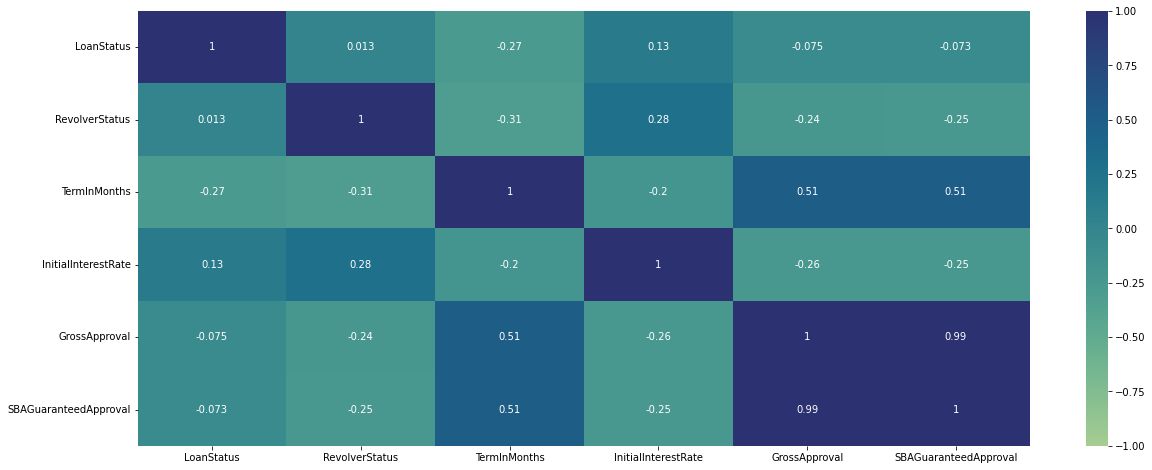

In [54]:
plt.figure(figsize=(20,8))
sns.heatmap(df[['LoanStatus', 'RevolverStatus', 'TermInMonths', 'InitialInterestRate', 'GrossApproval', 'SBAGuaranteedApproval']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

## Company Characteristics

In [56]:
df['JobsDummy'] = 0
df.loc[df.JobsSupported > 0, 'JobsDummy'] = 1

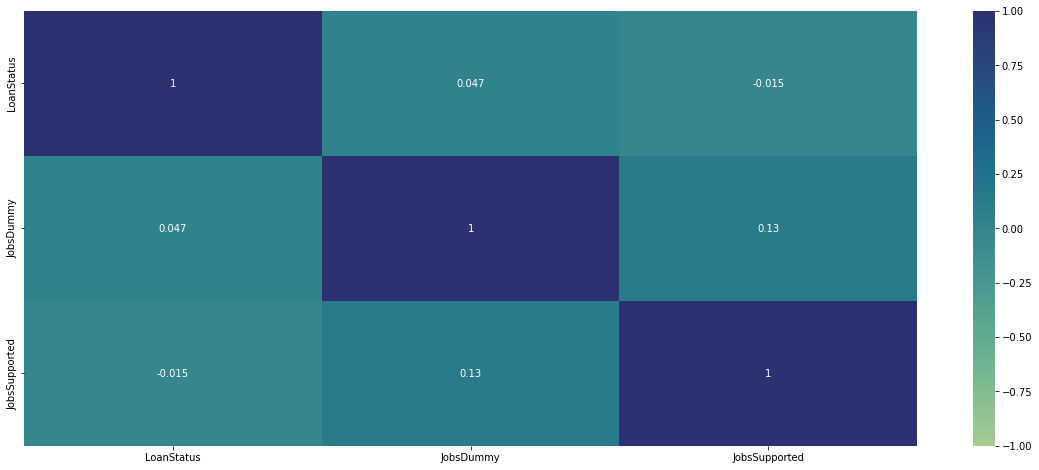

In [57]:
plt.figure(figsize=(20,8))
sns.heatmap(df[['LoanStatus', 'JobsDummy', 'JobsSupported']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [58]:
BorrNumLoansYear = df.groupby(['BorrName', 'ApprovalFiscalYear'])['BorrZip'].count().reset_index()
BorrNumLoansYear.rename(columns={'BorrZip':'BorrNumLoansYear'}, inplace=True)
df_BorrNumLoansYear = pd.merge(df, BorrNumLoansYear, how='left', on=['BorrName','ApprovalFiscalYear'])

In [60]:
df_BorrNumLoansYear[['LoanStatus', 'BorrNumLoansYear']].corr()

LoanStatus  BorrNumLoansYear
LoanStatus          1.000000         -0.008061
BorrNumLoansYear   -0.008061          1.000000

In [61]:
BorrNumLoansTotal = df.groupby(['BorrName'])['BorrZip'].count().reset_index()
BorrNumLoansTotal.rename(columns={'BorrZip':'BorrNumLoansTotal'}, inplace=True)
df_BorrNumLoansTotal = pd.merge(df, BorrNumLoansTotal, how='left', on=['BorrName'])

In [62]:
df_BorrNumLoansTotal[['LoanStatus', 'BorrNumLoansTotal']].corr()

LoanStatus  BorrNumLoansTotal
LoanStatus           1.000000          -0.010614
BorrNumLoansTotal   -0.010614           1.000000

In [63]:
df_DeliveryMethod = pd.merge(df[['LoanStatus']], pd.get_dummies(df['DeliveryMethod'], prefix = 'DeliveryMethod_'), how='inner', left_index = True, right_index = True)

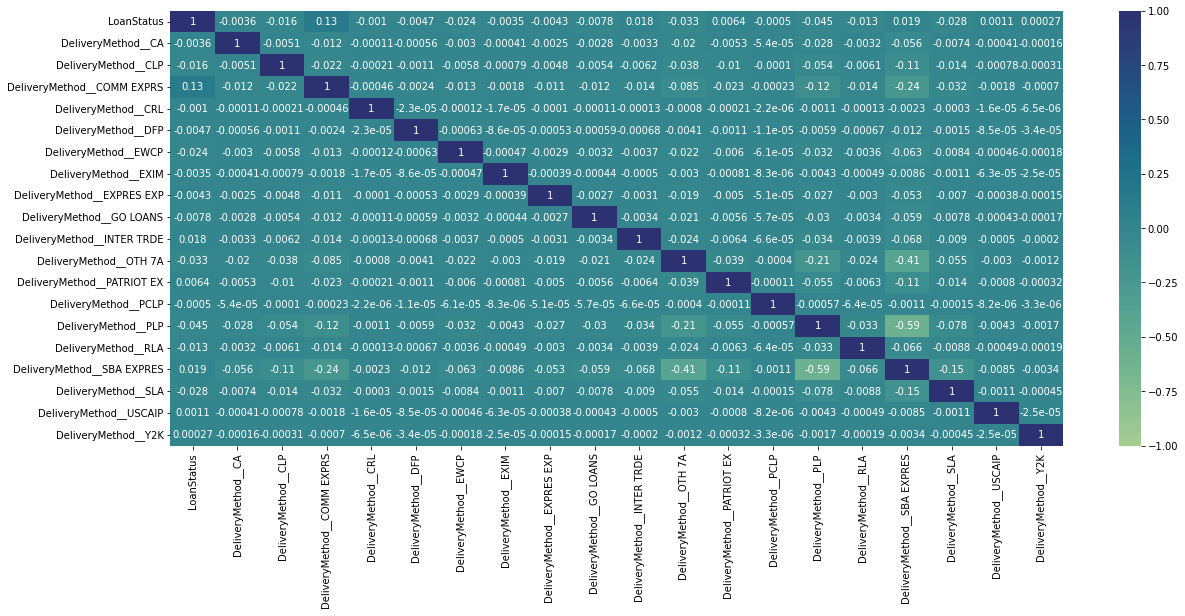

In [64]:
plt.figure(figsize=(20,8))
sns.heatmap(df_DeliveryMethod.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [65]:
df_subpgmdesc = pd.merge(df[['LoanStatus']], pd.get_dummies(df['subpgmdesc'], prefix = 'subpgmdesc_'), how='inner', left_index = True, right_index = True)

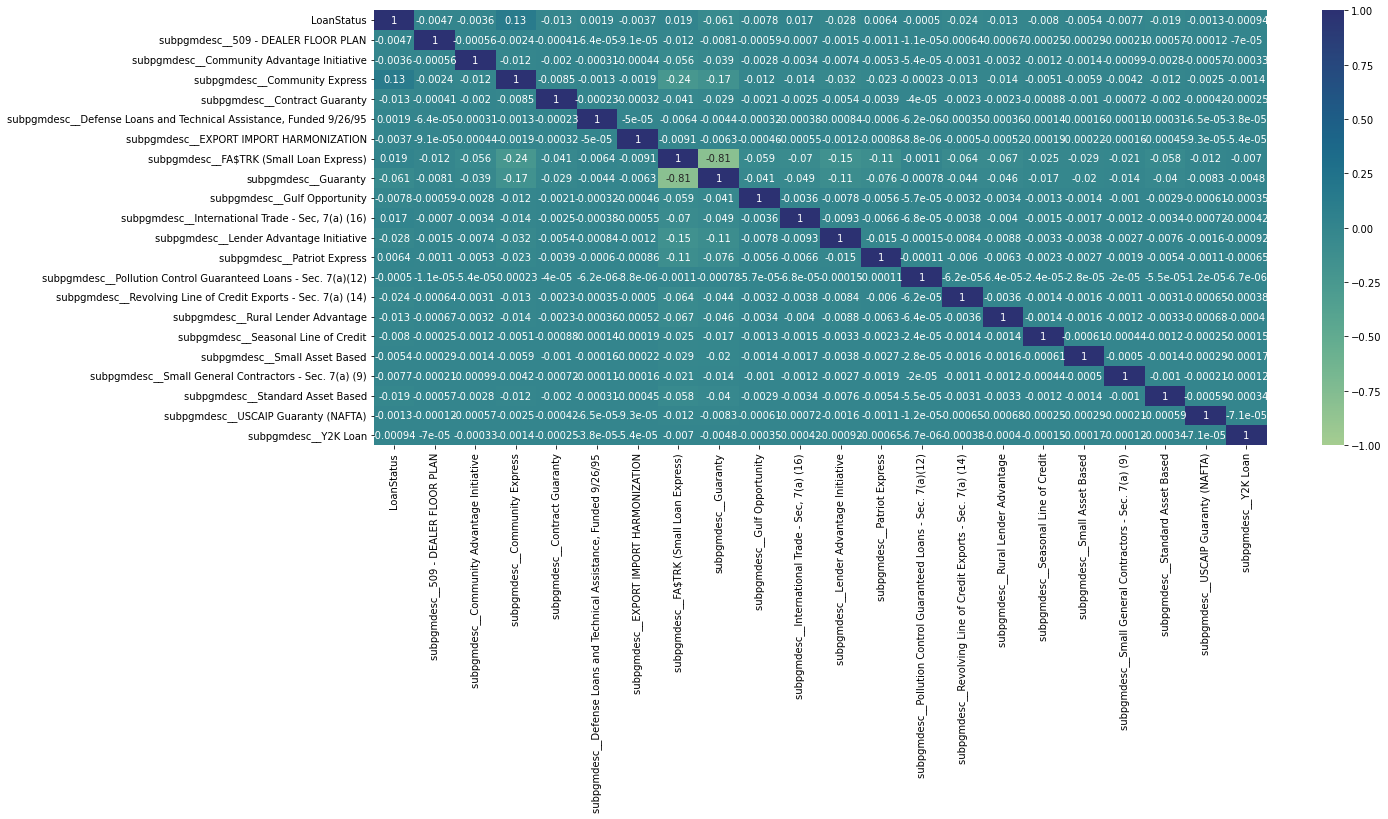

In [66]:
plt.figure(figsize=(20,8))
sns.heatmap(df_subpgmdesc.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [67]:
df_NaicsCode = df[['LoanStatus', 'NaicsCode']].copy().dropna()

df_NaicsCode['NaicsCode'] = df_NaicsCode['NaicsCode'].astype(str)
df_NaicsCode['NaicsCode'] = df_NaicsCode['NaicsCode'].str.slice(stop=2)
df_NaicsCode['NaicsCode'] = df_NaicsCode['NaicsCode'].astype(int)

df_NaicsCode = pd.merge(df_NaicsCode[['LoanStatus']], pd.get_dummies(df_NaicsCode['NaicsCode'], prefix = 'NaicsCode_'), how='inner', left_index = True, right_index = True) 

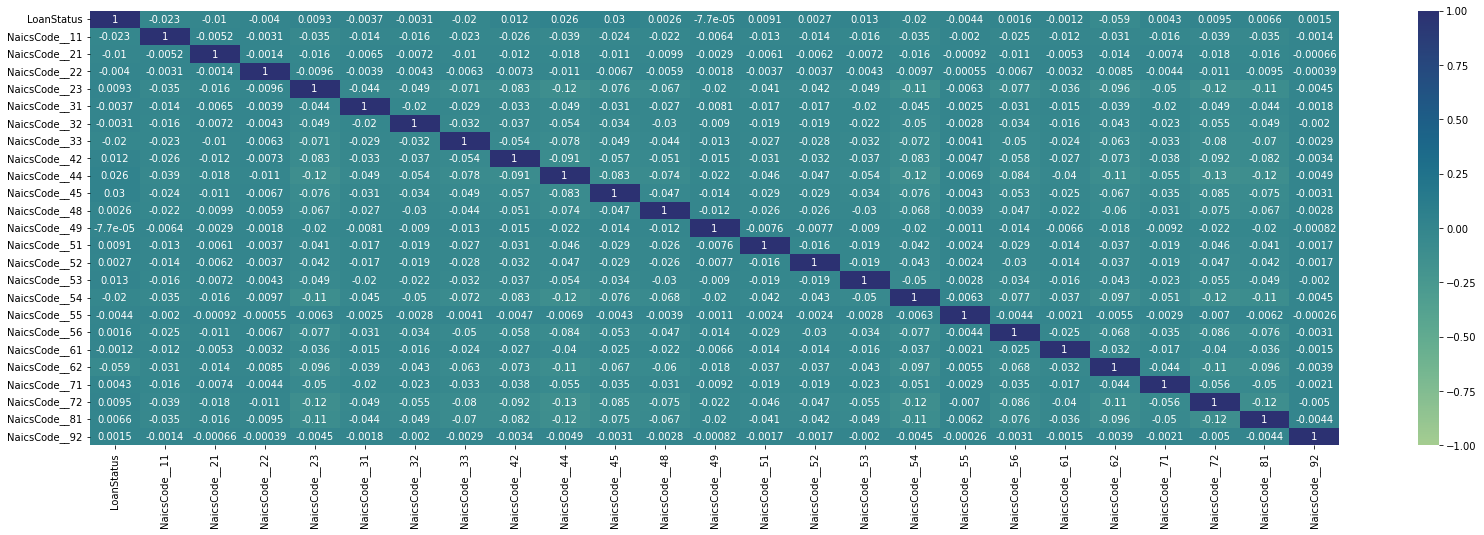

In [68]:
plt.figure(figsize=(28,8))
sns.heatmap(df_NaicsCode.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [69]:
df_FranchiseCode = df[['LoanStatus', 'FranchiseCode']].copy()
df_FranchiseCode.fillna('', inplace=True)

df_FranchiseCode['FranchiseCodeDummy'] = 0
df_FranchiseCode.loc[df_FranchiseCode.FranchiseCode != '', 'FranchiseCodeDummy'] = 1

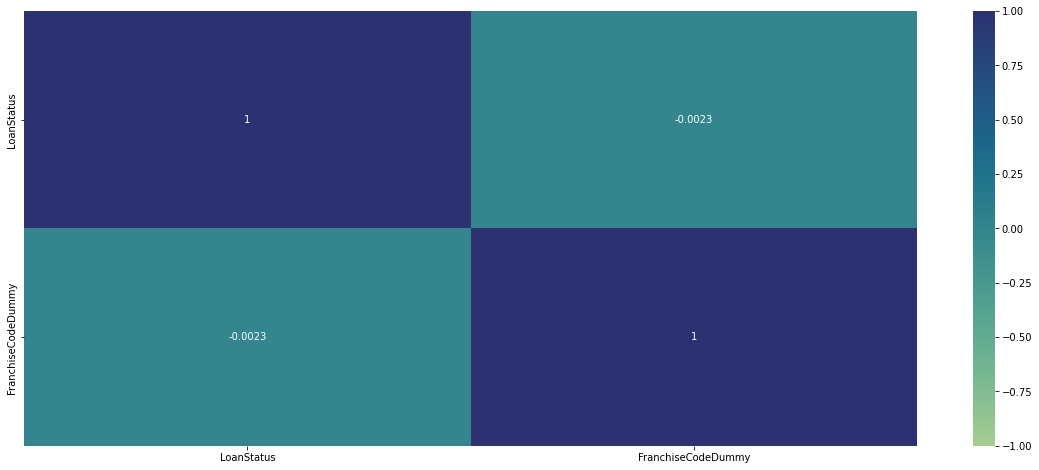

In [70]:
plt.figure(figsize=(20,8))
sns.heatmap(df_FranchiseCode[['LoanStatus', 'FranchiseCodeDummy']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [71]:
df_BusinessType = pd.merge(df[['LoanStatus']], pd.get_dummies(df['BusinessType'], prefix = 'BusinessType_'), how='inner', left_index = True, right_index = True)

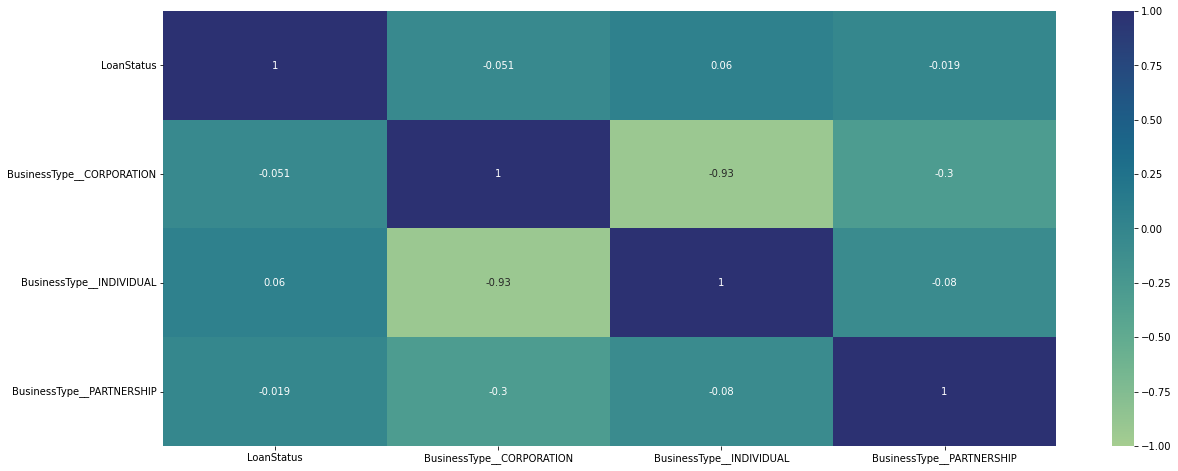

In [72]:
plt.figure(figsize=(20,8))
sns.heatmap(df_BusinessType.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

## Bank Characteristics

In [40]:
df_bank_zip = df[['LoanStatus', 'BorrZip', 'BankZip']].copy()

df_bank_zip['same'] = 0
df_bank_zip.loc[df_bank_zip.BankZip == df_bank_zip.BorrZip, 'same'] = 1

In [41]:
df_bank_zip

LoanStatus  BorrZip BankZip  same
0                0    94061   43240     0
1                0    84664   84601     0
2                0    28115   28387     0
3                1    85365   57104     0
4                0    55425   55102     0
...            ...      ...     ...   ...
916747           0    49101   46360     0
916748           0    28083   56301     0
916749           0     1940   02110     0
916750           0    92260   20429     0
916751           0    79912   79901     0

[916752 rows x 4 columns]

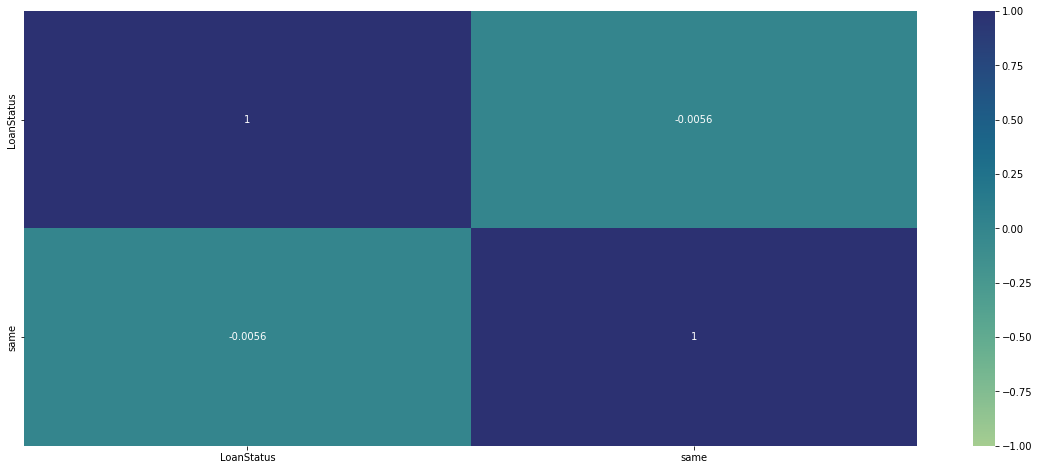

In [43]:
plt.figure(figsize=(20,8))
sns.heatmap(df_bank_zip[['LoanStatus', 'same']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [44]:
df_bank_state = df[['LoanStatus', 'BorrState', 'BankState']].copy()

df_bank_state['same'] = 0
df_bank_state.loc[df_bank_state.BankState == df_bank_state.BorrState, 'same'] = 1

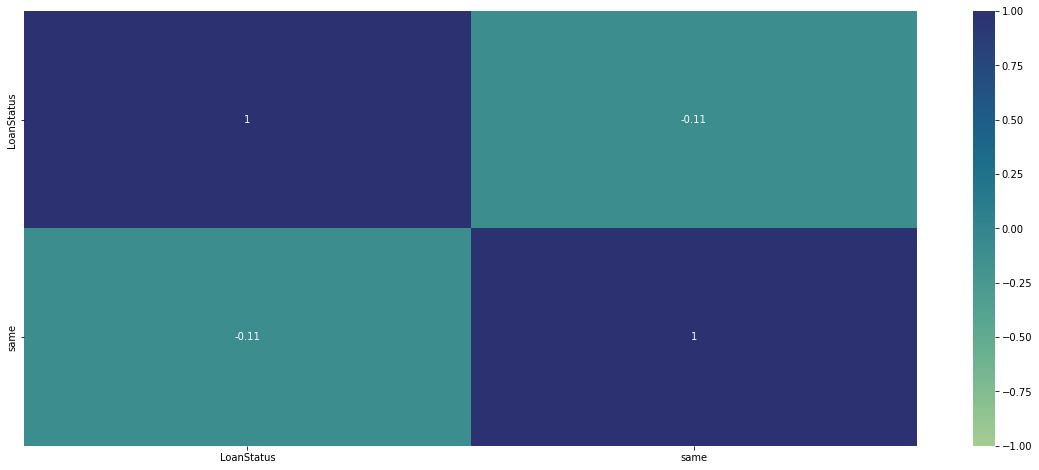

In [45]:
plt.figure(figsize=(20,8))
sns.heatmap(df_bank_state[['LoanStatus', 'same']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [76]:
BankNumLoansYear = df.groupby(['BankName', 'ApprovalFiscalYear'])['BankZip'].count().reset_index()
BankNumLoansYear.rename(columns={'BankZip':'BankNumLoansYear'}, inplace=True)
df_BankNumLoansYear = pd.merge(df, BankNumLoansYear, how='left', on=['BankName','ApprovalFiscalYear'])

In [77]:
df_BankNumLoansYear[['LoanStatus', 'BankNumLoansYear']].corr()

LoanStatus  BankNumLoansYear
LoanStatus          1.000000          0.180734
BankNumLoansYear    0.180734          1.000000

In [78]:
BankNumLoansTotal = df.groupby(['BankName'])['BankZip'].count().reset_index()
BankNumLoansTotal.rename(columns={'BankZip':'BankNumLoansTotal'}, inplace=True)
df_BankNumLoansTotal = pd.merge(df, BankNumLoansTotal, how='left', on=['BankName'])

In [79]:
df_BankNumLoansTotal[['LoanStatus', 'BankNumLoansTotal']].corr()

LoanStatus  BankNumLoansTotal
LoanStatus           1.000000           0.102971
BankNumLoansTotal    0.102971           1.000000

In [80]:
df_PctDefault = pd.merge(pd.DataFrame(df.groupby('BankName')['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'Count'}), 
                 pd.DataFrame(df.groupby('BankName')['LoanStatus'].sum()).reset_index(), 
                 how='inner', on='BankName')
df_PctDefault['PctDefault'] = df_PctDefault['LoanStatus']/df_PctDefault['Count']

In [81]:
df_PctDefault[['LoanStatus','PctDefault']].corr()

LoanStatus  PctDefault
LoanStatus    1.000000    0.030832
PctDefault    0.030832    1.000000

In [82]:
df_BankDefaults = pd.merge(pd.DataFrame(df.groupby('BankName')['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'LoanCounts'}), 
                           pd.DataFrame(df.groupby('BankName')['LoanStatus'].sum()).reset_index().rename(columns={'LoanStatus':'DefaultCounts'}), 
                           how='inner', on='BankName')
df_BankDefaults = pd.merge(df[['LoanStatus', 'BankName']], df_BankDefaults, how='inner', on='BankName')
df_BankDefaults['PctDefault'] = df_BankDefaults['DefaultCounts']/df_BankDefaults['LoanCounts']

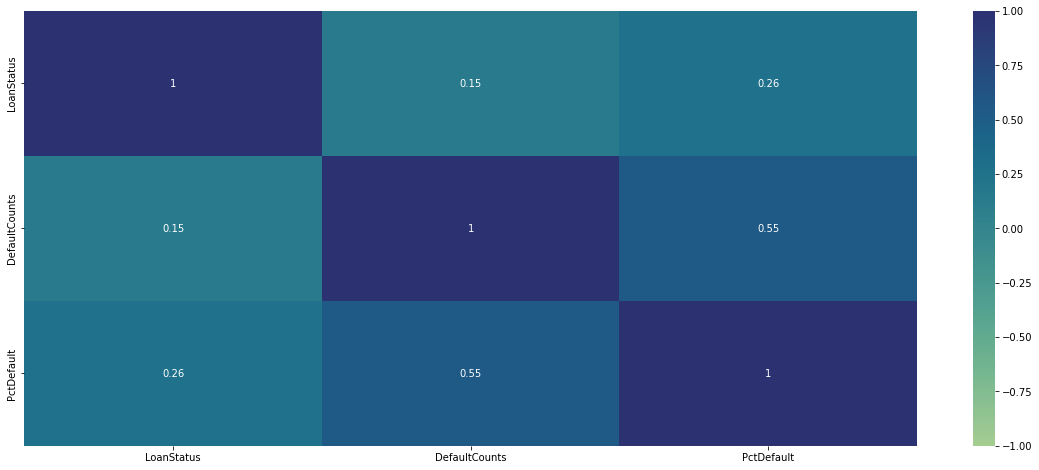

In [83]:
plt.figure(figsize=(20,8))
sns.heatmap(df_BankDefaults[['LoanStatus', 'DefaultCounts', 'PctDefault']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()


In [84]:
df_BankDefaultsYearly = pd.merge(pd.DataFrame(df.groupby(['BankName', 'ApprovalFiscalYear'])['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'LoanCounts'}), 
                           pd.DataFrame(df.groupby(['BankName', 'ApprovalFiscalYear'])['LoanStatus'].sum()).reset_index().rename(columns={'LoanStatus':'DefaultCounts'}), 
                           how='inner', on=['BankName', 'ApprovalFiscalYear'])
df_BankDefaultsYearly = pd.merge(df[['LoanStatus', 'BankName', 'ApprovalFiscalYear']], df_BankDefaultsYearly, how='inner', on=['BankName', 'ApprovalFiscalYear'])
df_BankDefaultsYearly['PctDefault'] = df_BankDefaultsYearly['DefaultCounts']/df_BankDefaultsYearly['LoanCounts']

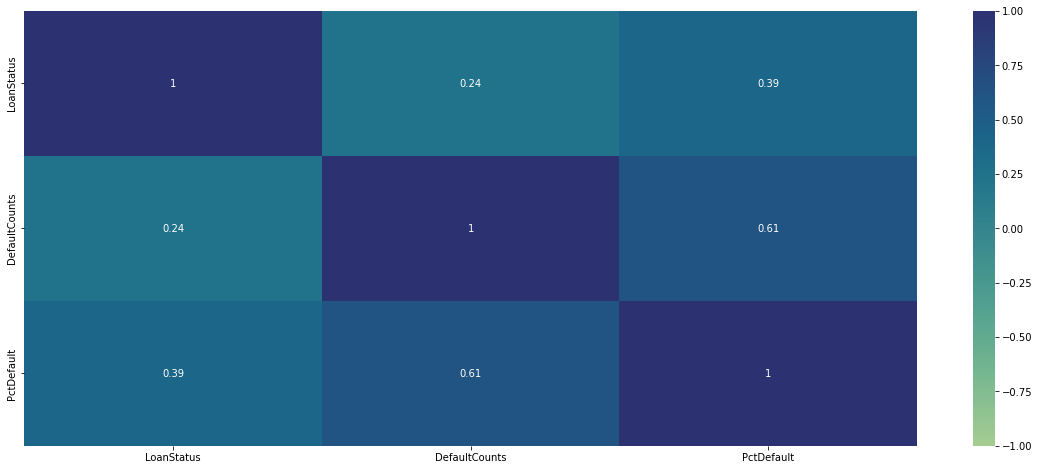

In [85]:
plt.figure(figsize=(20,8))
sns.heatmap(df_BankDefaultsYearly[['LoanStatus', 'DefaultCounts', 'PctDefault']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

## Feature Engineering

In [ ]:
# age of the loan, as the loan is held on longer, more odds to default - look at the length of payed back loans and defaulted loans ChargeOffDate/PaidInFullDate and FirstDisbursementDate
# should look at bank default cumalitive to year prior. So for a loan in 2015, consider 2010-2014 cumaltive default rate
# dummy variables for fiscal approval date
# try three digit zips - need to pad and then take the first three

In [57]:
df_Year = pd.merge(df[['LoanStatus']], pd.get_dummies(df['ApprovalFiscalYear'], prefix = 'ApprovalFiscalYear_'), how='inner', left_index = True, right_index = True)

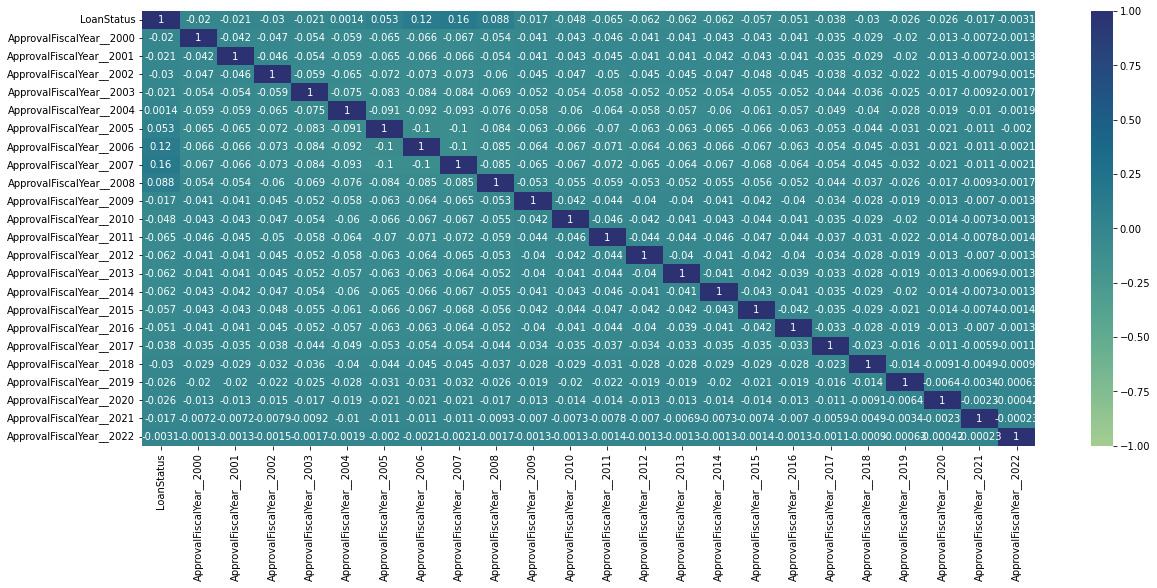

In [58]:
plt.figure(figsize=(20,8))
sns.heatmap(df_Year.corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()

In [59]:
df[['ChargeOffDate', 'PaidInFullDate', 'FirstDisbursementDate']]

ChargeOffDate PaidInFullDate FirstDisbursementDate
0                NaN     11/30/2020            10/31/2019
1                NaN     01/31/2022            10/31/2019
2                NaN     11/30/2021            11/30/2019
3         12/15/2021            NaN            11/30/2019
4                NaN     02/28/2022            10/31/2019
...              ...            ...                   ...
916747           NaN     07/31/2013            02/01/2010
916748           NaN     03/31/2014            10/01/2009
916749           NaN     05/31/2018            12/01/2009
916750           NaN     11/30/2010            10/01/2009
916751           NaN     01/31/2011            04/01/2010

[916752 rows x 3 columns]

In [60]:
df_Length = df[['BorrName', 'BankName', 'ApprovalDate', 'ChargeOffDate', 'PaidInFullDate', 'FirstDisbursementDate']].copy()

df_Length = df_Length[df_Length['FirstDisbursementDate'].notna()]

df_Length['Initial'] = df_Length['FirstDisbursementDate'].str.slice(start=6)
df_Length['Initial'] = df_Length['Initial'].astype(int)

df_Length['Final'] = df_Length['PaidInFullDate']
df_Length.loc[pd.isna(df_Length['Final']), 'Final'] = df_Length['ChargeOffDate']

df_Length = df_Length[df_Length['Final'].notna()]

df_Length['Final'] = df_Length['Final'].str.slice(start=6)
df_Length['Final'] = df_Length['Final'].astype(int)

df_Length['Length'] = df_Length['Final'] - df_Length['Initial']

df_Length = pd.merge(df[['LoanStatus', 'ChargeOffDate', 'PaidInFullDate', 'FirstDisbursementDate', 'BorrName', 'BankName', 'ApprovalDate']], 
                     df_Length, 
                     how='inner', 
                     on=['ChargeOffDate', 'PaidInFullDate', 'FirstDisbursementDate', 'BorrName', 'BankName', 'ApprovalDate']).drop_duplicates()

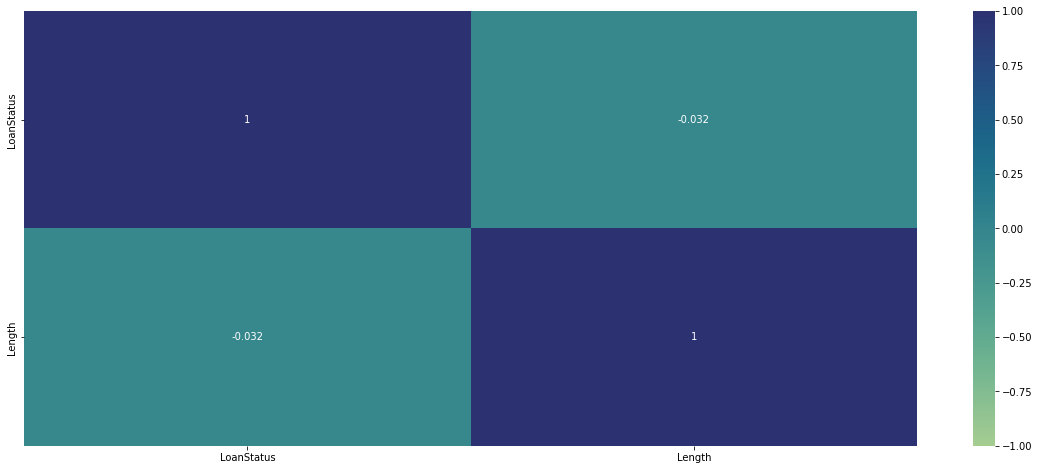

In [72]:
plt.figure(figsize=(20,8))
sns.heatmap(df_Length[['LoanStatus', 'Length']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()


In [69]:
# try three digit zips - need to pad and then take the first three
df_Zip = df[['LoanStatus', 'BorrZip', 'BankZip']].copy()
df_Zip['BorrZip'] = df_Zip['BorrZip'].astype(str).str.zfill(5).str.slice(stop=3)
df_Zip['BankZip'] = df_Zip['BankZip'].astype(str).str.zfill(5).str.slice(stop=3)

df_Zip['same'] = 0
df_Zip.loc[df_Zip.BankZip == df_Zip.BorrZip, 'same'] = 1

In [70]:
df_Zip.same.value_counts()

0    813067
1    103685
Name: same, dtype: int64

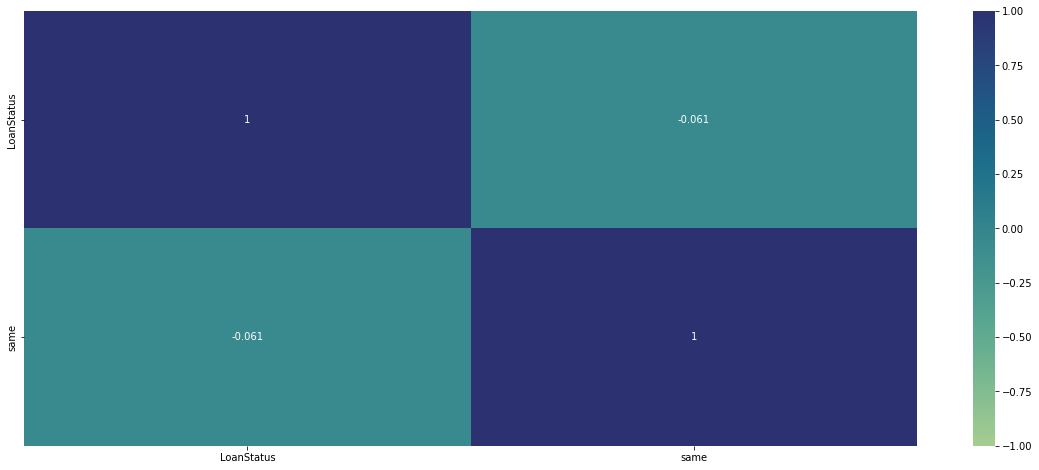

In [73]:
plt.figure(figsize=(20,8))
sns.heatmap(df_Zip[['LoanStatus', 'same']].corr(), vmin = -1, vmax = 1, annot=True, cmap = 'crest')
plt.show()


In [ ]:
# look at bank default cumalitive to year prior. So for a loan in 2015, consider 2010-2014 cumaltive default rate

In [94]:
df_BankDefaultsYearlyCumsum = pd.merge(pd.DataFrame(df.groupby(['BankName', 'ApprovalFiscalYear'])['LoanStatus'].count()).reset_index().rename(columns={'LoanStatus':'LoanCountsYear'}), 
                                       pd.DataFrame(df.groupby(['BankName', 'ApprovalFiscalYear'])['LoanStatus'].sum()).reset_index().rename(columns={'LoanStatus':'DefaultCountsYear'}), 
                                       how='inner', on=['BankName', 'ApprovalFiscalYear'])

df_BankDefaultsYearlyCumsum = df_BankDefaultsYearlyCumsum.sort_values(['BankName', 'ApprovalFiscalYear'], axis=0, ascending=True)

df_BankDefaultsYearlyCumsum['CumDefault'] = df_BankDefaultsYearlyCumsum.groupby(['BankName'])['DefaultCountsYear'].transform(pd.Series.cumsum)
df_BankDefaultsYearlyCumsum['CumLoansIssued'] = df_BankDefaultsYearlyCumsum.groupby(['BankName'])['LoanCountsYear'].transform(pd.Series.cumsum)

df_BankDefaultsYearlyCumsum['PctDefault'] = df_BankDefaultsYearlyCumsum['CumDefault']/df_BankDefaultsYearlyCumsum['CumLoansIssued']
df_BankDefaultsYearlyCumsum = pd.merge(df[['LoanStatus', 'BankName', 'ApprovalFiscalYear']], df_BankDefaultsYearlyCumsum, how='inner', on=['BankName', 'ApprovalFiscalYear'])


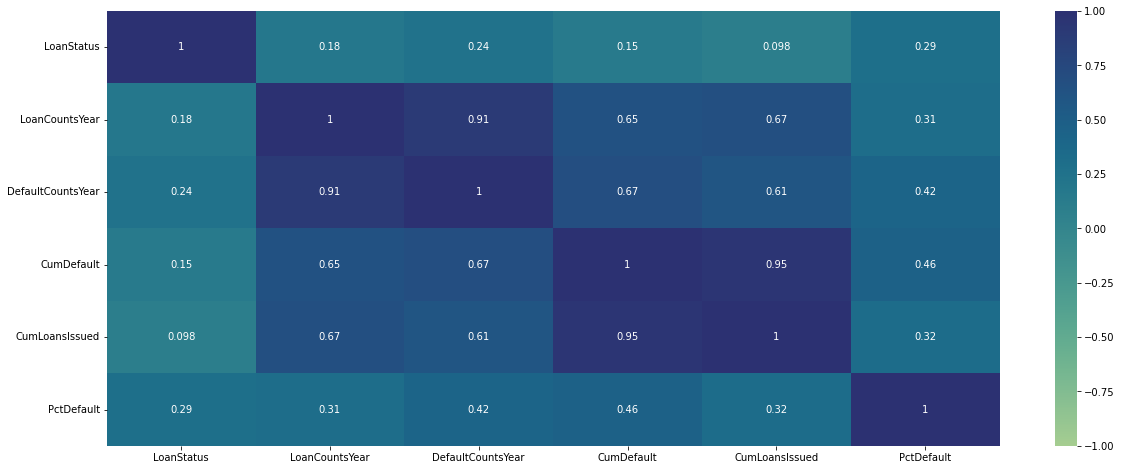

In [96]:
plt.figure(figsize=(20,8))
sns.heatmap(df_BankDefaultsYearlyCumsum[['LoanStatus', 'LoanCountsYear', 'DefaultCountsYear', 'CumDefault', 'CumLoansIssued', 'PctDefault']].corr(), 
            vmin = -1, 
            vmax = 1, 
            annot=True, 
            cmap = 'crest')
plt.show()

In [ ]:
# multiple loans by a borrower in their approval year

In [112]:
df_MultipleLoansYear = pd.merge(df.groupby(['BorrName', 'ApprovalFiscalYear'])['LoanStatus'].count().reset_index().rename(columns={'LoanStatus':'LoanCountYear'}),
                                df[['LoanStatus', 'BorrName', 'ApprovalFiscalYear']],
                                how='inner',
                                on=['BorrName', 'ApprovalFiscalYear']).drop_duplicates()

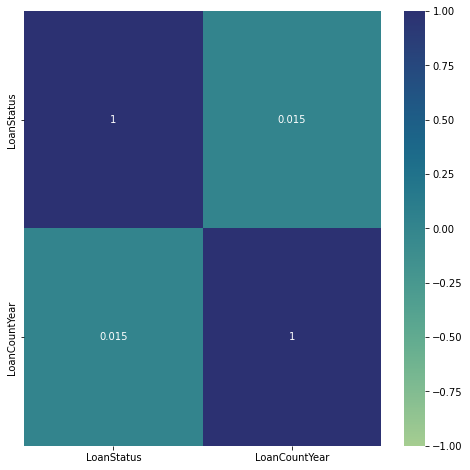

In [113]:
plt.figure(figsize=(8,8))
sns.heatmap(df_MultipleLoansYear[['LoanStatus', 'LoanCountYear']].corr(), 
            vmin = -1, 
            vmax = 1, 
            annot=True, 
            cmap = 'crest')
plt.show()